In this notebook, we repeat the 3 rings experiment in Kale flow code. The code in the Kale gradient descent section is taken directly from theirs. Here we use simple gradient descent we constant stepsize for the optimization of KKL.

In [1]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import scipy.optimize as sco 
import os
import ot
import pickle


In [2]:
plt.rcParams['xtick.labelsize'] = 20  
plt.rcParams['ytick.labelsize'] = 20  
plt.rcParams['legend.fontsize'] = 15  
plt.rcParams['axes.labelsize'] = 20   
plt.rcParams['axes.titlesize'] = 20  

In [34]:
def _generate_data():
    N, r, _delta = 80, 0.3, 0.5
    
    X = np.c_[r * np.cos(np.linspace(0, 2 * np.pi, N + 1)), r * np.sin(np.linspace(0, 2 * np.pi, N + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = np.r_[X, X[:N, :]-i*np.array([0, (2 + _delta) * r])]

    rs = np.random.RandomState(42)
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([r/np.sqrt(2), r/np.sqrt(2)])
    Y = rs.randn(N*(2+1), 2) / 100 - np.array([0, r])

    Y = torch.from_numpy(Y).float()
    X = torch.from_numpy(X).float()
    Y.requires_grad = True
    return X, Y

# Kale flow

In [4]:
import logging 
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.gradient_flow_2 import gradient_flow
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kernels import gaussian_kernel
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.config import LOG_LEVELS

In [7]:
from kale_flow_master.kernel_wasserstein_flows.kernel_wasserstein_flows.kale import kale_penalized, kale_penalized_first_variation
def _gen():
    return X, Y

_gf_default_kwargs = dict(
    max_iter=50000,
    random_seed=20,
    noise_level_callback=lambda x: 1e-10,
    num_noisy_averages=1,
    generator=_gen,
    generator_kwargs=dict(),
    kernel=gaussian_kernel,
    kernel_kwargs={'sigma': 0.1},
    loss=kale_penalized,
    loss_first_variation=kale_penalized_first_variation
)

_kale_default_kwargs = {
    "inner_max_iter": 800,
    "inner_tol": 1e-6,
    "inner_a": 0.4,
    "inner_b": 0.8,
    "inplace": False,
    "input_check":True,
    "dual_gap_tol": 1e-2,
    "optimization_method":"newton",
}

In [8]:
results = {}

In [9]:
import time 
import torch

for _lambda_, lr, exp_name in zip([0.001, 10000], [0.0001, 0.001], ['kale_0001', 'kale_10000']):
    t0 = time.time()
    X,Y = _generate_data()
    args, (X, Y), (trajectories, records, loss_states) = gradient_flow(lr=lr, loss_kwargs={**_kale_default_kwargs, 'lambda_': _lambda_}, **_gf_default_kwargs)
    print(f'total time {time.time() - t0:.3f}s')
    results[exp_name] = { 
        'args': args,
        'X': X,
        'Y': Y,
        'trajectories': trajectories,
        'records': records,
        'loss_states': loss_states
    }

 gradient_flow: X.requires_grad: False, Y.requires_grad: True
 gradient_flow: X.requires_grad: False, Y.requires_grad: True


total time 698.793s
total time 641.523s


In [10]:
name = 'kale_3rings_300it.npy'
print(name)
np.save('save_data/3_rings/'+name, results["kale_0001"]['trajectories'])

name = 'mmd_3rings_300_it.npy'
print(name)
np.save('save_data/3_rings/'+name, results["kale_10000"]['trajectories'])

kale_3rings_300it.npy
mmd_3rings_300_it.npy


In [22]:
mmd_X = results["kale_10000"]['trajectories']
Kale_X = results["kale_0001"]['trajectories']

# KKL Gradient descent

C:\Users\cleme\DOC\Annee_2023_2024\code\Regularized\kkl\divergences.py:10: RuntimeWarning: invalid value encountered in log
  return np.where(t > 0, np.log(t), 0.)


total time : 329.74933767318726


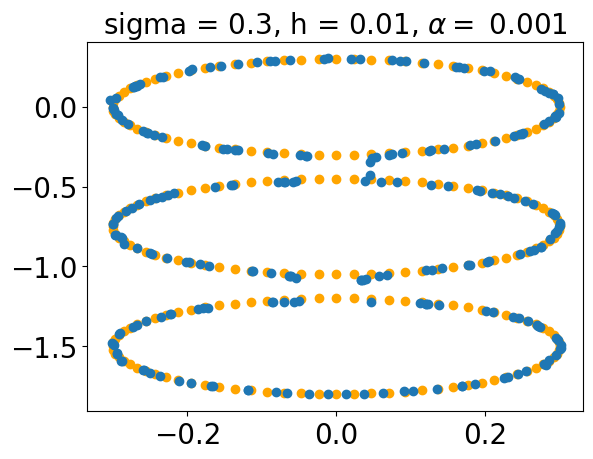

In [35]:
import kkl.divergences as dv
import kkl.kernels as kl
import kkl.gradient_descent as gd
import kkl.generate_data as gy
import time

##DATA##
y,x = _generate_data()
x = x.detach().numpy()
y = y.detach().numpy()

n = len(x)
m = len(y)
T = 300 # nombre d'itérations
eps = 0.0001
Alpha = [0.1,0.01,0.001]
Sigma = [0.1,0.3,0.4]
H = [0.005,0.01,0.05]

data = [] 
for alpha in [0.001]:
    for sigma in [0.3]:
        for h in [0.01]:
    #### DIVERGENCE ####
    
            k = lambda x,y :  kl.k_gauss(x,y,sigma)
            dk = lambda x,y : kl.dk_gauss(x, y,sigma)
            Ky = 1/m * k(y,y) 

            J = lambda x : dv.KKL(x, y, k, Ky, alpha) 
            dJ = lambda x : dv.WGrad_KKL(x, y, k, dk, Ky, alpha, sigma) 

            ###########################################
            ############ GRADIENT DESCENT #############
            ###########################################

            x0 = x
            t0 = time.time()
            X = gd.gradient_descent(J, dJ, x0, h, eps, T)
            print("total time : " + str(time.time()-t0))
            data.append({'alpha': alpha, 'h': h, 'sigma': sigma, 'X': X})

            plt.figure()  
            plt.scatter(y[:,0],y[:,1],color = "orange")  
            plt.scatter(X[-1,:,0], X[-1,:,1])
            plt.title("sigma = " + str(sigma) + ", h = " + str(h) + r", $\alpha =$ " + str(alpha))

df = pd.DataFrame(data)

In [37]:
with open('results.pkl', 'wb') as f:
    pickle.dump(df, f)

In [38]:
with open('results.pkl', 'rb') as f:
    df = pickle.load(f)

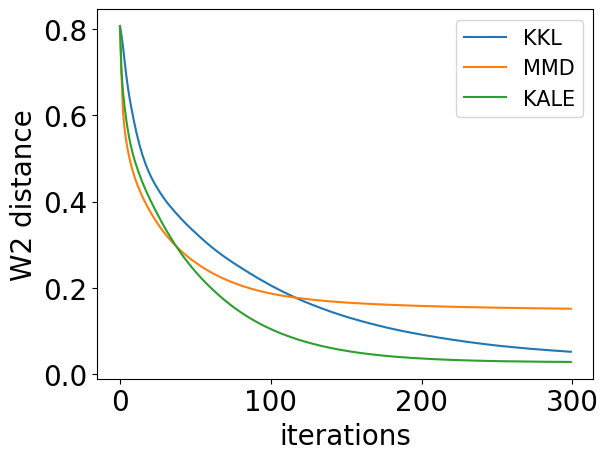

In [46]:
plt.figure()
Wass2_mmd = []
Wass2_kale = []
Wass2_kkl = []
for t in range(300):
    a = np.ones((len(mmd_X[t]),)) / len(mmd_X[t])
    b = np.ones((len(y),)) / len(y)
    M = ot.dist(mmd_X[t],y)
    Wass2_mmd.append(np.sqrt(ot.emd2(a, b, M)))
    a = np.ones((len(Kale_X[t]),)) / len(Kale_X[t])
    b = np.ones((len(y),)) / len(y)
    M = ot.dist(Kale_X[t],y)
    Wass2_kale.append(np.sqrt(ot.emd2(a, b, M)))

for alpha in [0.001]: #Alpha:
    for sigma in [0.3]:
        for h in [0.01]:
            Wass2_kkl = []
            for t in range(300):
                x_t = df[(df['alpha'] == alpha) & (df['h'] == h) & (df['sigma'] == sigma)]['X'].values[0][t]
                a = np.ones((len(x_t),)) / len(x_t)
                b = np.ones((len(y),)) / len(y)
                M = ot.dist(x_t,y)
                Wass2_kkl.append(np.sqrt(ot.emd2(a, b, M)))
            plt.plot(Wass2_kkl,label = "KKL") 
        plt.plot(Wass2_mmd,label = "MMD" )
        plt.plot(Wass2_kale, label = "KALE")
        plt.xlabel("iterations")
        plt.ylabel("W2 distance")
        plt.legend()
    
output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, '3_rings_300it_wass_dist.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 300,bbox_inches='tight')

In [41]:
X = df[(df['alpha'] == 0.001) & (df['h'] == 0.01) & (df['sigma'] == 0.3)]['X'].values[0]

# Plots

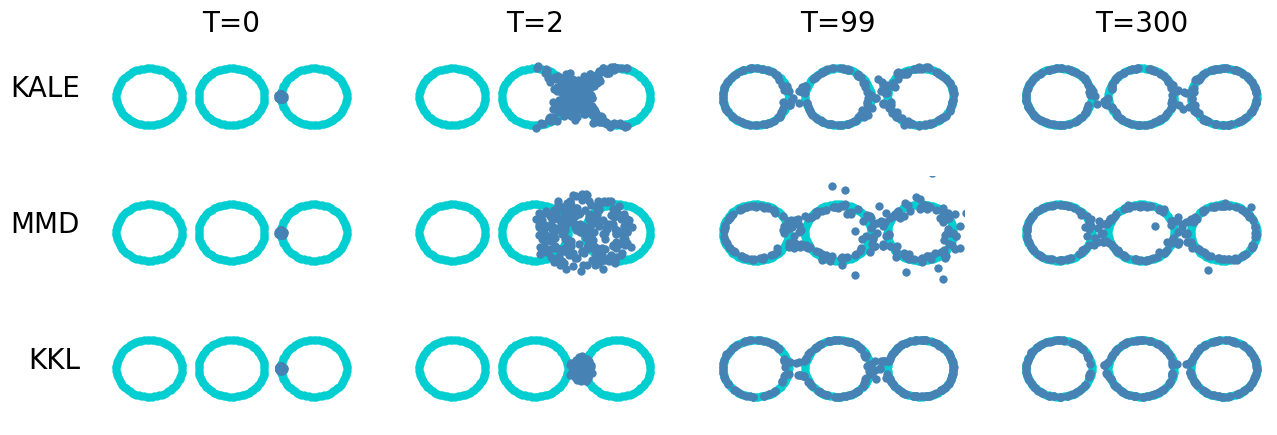

In [42]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 5))
    
iters = [0, 2, 99, 300]

axs[0,0].text(-0.1, 0.5, "KALE", size=20, transform=axs[0,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[0]):
    ax.set_title(f'T={it}')
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    if it < 400:
        ax.scatter(y[:, 1], y[:, 0],color = "darkturquoise",linewidths=1e-5)
        ax.scatter(Kale_X[it, :, 1],Kale_X[it, :, 0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[1,0].text(-0.1, 0.5, "MMD", size=20, transform=axs[1,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[1]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    if it < 400:
        ax.scatter(y[:, 1], y[:, 0],color = "darkturquoise",linewidths=1e-5)
        ax.scatter(mmd_X[it, :, 1], mmd_X[it, :, 0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    
axs[2,0].text(-0.1, 0.5, "KKL", size=20, transform=axs[2,0].transAxes, horizontalalignment='right')
for it,ax in zip(iters, axs[2]):
    ax.set_xlim([-1.9, 0.4])
    ax.set_ylim([-0.6, 0.6])
    ax.scatter(y[:,1],y[:,0],color = "darkturquoise",linewidths=1e-5)
    #ax.scatter(positions[it][:,1],positions[it][:,0],color = "steelblue")
    ax.scatter(X[it][:,1],X[it][:,0],color = "steelblue",linewidths=1e-5)
    ax.axis('off')
    

    
output_dir = 'plots_neurips/3_rings'
output_path = os.path.join(output_dir, '3rings_alpha_0_01.pdf')
if os.path.exists(output_path):
    os.remove(output_path)
    
plt.savefig(output_path,dpi = 300,bbox_inches='tight')
    

        